# Базовое решение задачи kaggle "Classification of butterflies"

Описание задачи и данные:

https://www.kaggle.com/c/classification-of-butterflies/data

In [1]:
# сохраним все данные в папку на гугл диске
# монтируем гугл диск в colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install opendatasets

In [4]:
import opendatasets as od
od.download("https://www.kaggle.com/competitions/classification-of-butterflies/overview")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: torpedorkl
Your Kaggle Key: ··········


100%|██████████| 132M/132M [00:08<00:00, 15.8MB/s]



Extracting archive ./classification-of-butterflies/classification-of-butterflies.zip to ./classification-of-butterflies


In [24]:
import cv2

In [5]:
import re
import pandas as pd
import os

# с помощью библиотеки os перейдем в папку где лежат данные
# url = os.chdir(r"./gdrive/MyDrive/Я-профи подготовка по машинному обучению/butterfles")
# os.getcwd()

## Считывание данных

Для применения алгоритмов ML необходимо чтобы изображения были одного размера, но нам повезло по условию, они уже все одного размера

Метод фреймворка Tensorflow `image_dataset_from_directory` - Позволяет их картинок создать тренировочный набор данных, картинки размещены по разным папкам, что и является разметкой классов по сути

https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

In [6]:
import tensorflow as tf

In [7]:
# считаем тренировочные данные

# 224 - ширина, 224 - высота, 3 - количество каналов (для цветных картинок RGB - значит 3 канала)
img_shape=(224,224,3)

# train_dir - путь до тренировочных данных
train_dir = os.path.join('/content/classification-of-butterflies/train_butterflies/train_split')

img_size = (img_shape[0], img_shape[1])

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    seed=123,
    batch_size=15)

Found 4955 files belonging to 50 classes.


In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# train_genarator = ImageDataGenerator(rescale=1. /255)

# train_genarator.flow_from_directory()

In [8]:
valid_dir = os.path.join('/content/classification-of-butterflies/test_butterflies')
img_size = (img_shape[0], img_shape[1])
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    valid_dir,
    image_size=img_size,
    seed=123,
    batch_size=15)

Found 250 files belonging to 1 classes.


In [9]:
# считаем тестовые данные
# label_mode - установлен как None, потому что тестовые данные не размеченные
# Остальные параменты должны совпадать с тренировных набором данны

# test_dir - путь до тестовых данных
test_dir = os.path.join('/content/classification-of-butterflies/test_butterflies')

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode = None,
    image_size=img_size,
    batch_size=15)

Found 250 files belonging to 1 classes.


In [11]:
# train_ds - созданный набор тренировочных данных созданный с помощью Tensorflow
# class_names - метод объекта данных Tensorflow который возвращает список всех классов в виде списка
class_names = train_ds.class_names

# всего 50 классов, что мы собственно и видим после того как считали тренировочные данные
class_count = len(class_names)

In [ ]:
# названия классов совпадают с названием папок
class_names

InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 15 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

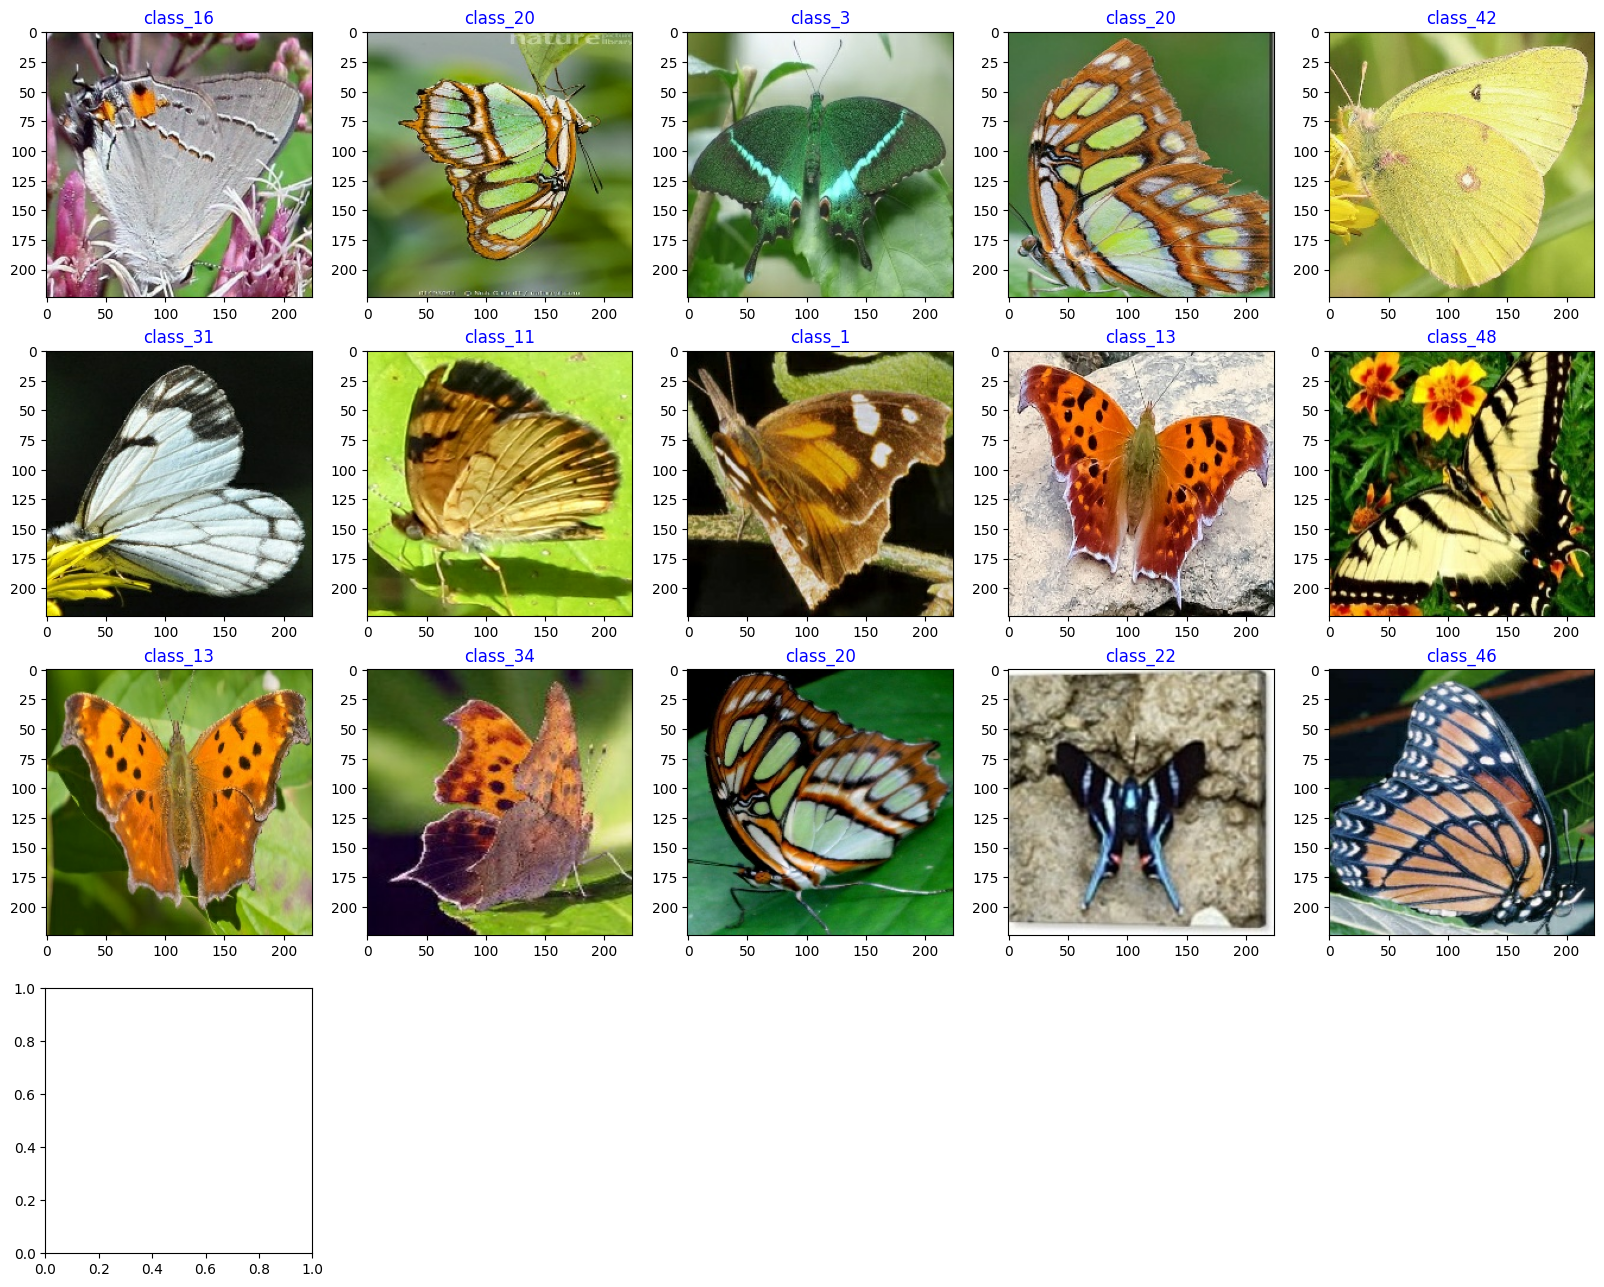

In [12]:
# посмотрим на некоторые картинки из набора тренировочных данных
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))

for images, labels in train_ds.take(1):
    for i in range (25):
        plt.subplot(5,5,i +1)
        img=images[i]/255
        plt.title(class_names[labels[i]], color='blue', fontsize=12)
        plt.imshow(img)
    plt.show()

## Построение модели

**Слой `Input`**

Помимо функциональных слоев в Keras существуют вспомогательные слои и один из них определяется классом `Input`.

Как вы уже догадались, этот слой служит для описания формы входных данных. То есть, если модель не имеет слоя Input, то размерность входного вектора устанавливается по входному тензору при первом вызове.

Но, если явно указать размерность через класс Input, то модель сети строится сразу с начальным набором весов.

Нейронная сеть архитектуры **EfficientNetB3**, которая обучена на наборе данных UTKFace DataSet.

Возьмем готовую архитектуру для решения задачи (можете еще ResNet попробовать).

https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB3

`Model` - Модель это (обычно) граф слоев.


https://www.tensorflow.org/api_docs/python/tf/keras/Model

`Adamax` – вариант оптимизации по Adam, но без ограничений по норме.

Модели глубоко обучения

https://keras.io/api/applications/#xception

In [44]:
%%time
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax

input = Input(shape = img_shape)

x = tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet", pooling='max')(input)
# x = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)

x = Dropout(rate=.2, seed=123)(x)

output = Dense(class_count, activation='softmax')(x)

model = Model(inputs = input, outputs = output)

# model.compile(Adamax(lr=.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.compile(
    optimizer = Adamax(lr=.001),
    loss = tf.losses.SparseCategoricalCrossentropy(),
    # CategoricalCrossentropy()
    metrics = ['accuracy'])

history = model.fit(train_ds, validation_data = valid_ds, epochs = 6, verbose = 1)

Epoch 1/6
331/331 [==============================] - 139s 255ms/step - loss: 1.6453 - accuracy: 0.6634 - val_loss: 13.8133 - val_accuracy: 0.0200
Epoch 2/6
331/331 [==============================] - 82s 247ms/step - loss: 0.2714 - accuracy: 0.9233 - val_loss: 15.3267 - val_accuracy: 0.0200
Epoch 3/6
331/331 [==============================] - 84s 253ms/step - loss: 0.1409 - accuracy: 0.9594 - val_loss: 17.4524 - val_accuracy: 0.0200
Epoch 4/6
331/331 [==============================] - 83s 250ms/step - loss: 0.1032 - accuracy: 0.9691 - val_loss: 17.8900 - val_accuracy: 0.0200
Epoch 5/6
331/331 [==============================] - 82s 248ms/step - loss: 0.0711 - accuracy: 0.9802 - val_loss: 18.7679 - val_accuracy: 0.0200
Epoch 6/6
331/331 [==============================] - 86s 259ms/step - loss: 0.0734 - accuracy: 0.9796 - val_loss: 19.5160 - val_accuracy: 0.0200
CPU times: user 8min 29s, sys: 17.4 s, total: 8min 46s
Wall time: 11min 54s


In [45]:
acc = history.history['accuracy']
loss = history.history['loss']

In [46]:
epochs = range(1,len(acc)+1)

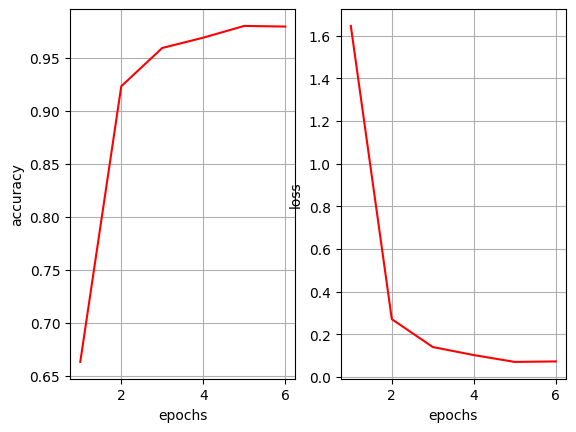

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(epochs, acc, 'r', label="Training Accuracy")
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epochs')
ax1.grid()

ax2.plot(epochs, loss, 'r', label="Training Loss")
ax2.set_ylabel('loss')
ax2.set_xlabel('epochs')
ax2.grid()

plt.show()

In [48]:
test_path = '/content/classification-of-butterflies/test_butterflies/valid'

test = {
    'img': [],
    'index': []
}

for file in os.listdir(test_path):
    img = cv2.imread(f'{test_path}/{file}')
    test['img'].append(
        cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    )
    test['index'].append(int(file.replace('.jpg', '')))

test = {
    'img': np.array(test['img']),
    'index': np.array(test['index'])
}

preds = model.predict(test['img'], verbose=1)
preds

import numpy as np

ypred = []
for i, p in enumerate(preds):
    index = np.argmax(p)
    klass = class_names[index]
    ypred.append(klass)

ypred = np.array(ypred)
df = pd.DataFrame(ypred, columns=['label'])
df['label'] = df['label'].str.replace("class_",'')
df['label'] = df['label'].astype(int)
df = df.reset_index()
df['index'] = test['index']

8/8 [==============================] - 4s 108ms/step


In [29]:
type(history)

keras.src.callbacks.History

In [28]:
from tensorflow.keras.applications.efficientnet import EfficientNetB7

In [49]:
from google.colab import files

df.to_csv('predictions2.csv', index=False)
files.download('predictions2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
ans = pd.read_csv('gdrive/MyDrive/butterflies/predictions.csv')

In [20]:
ans

,index,label
0,0,18
1,1,7
2,2,7
3,3,28
4,4,9
...,...,...
245,245,36
246,246,24
247,247,4
248,248,0
